## Import the Data and Preprocessing...

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
#from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip"
cols = ['Date', 'Time', 'Global_active_power', 'Global_reactive_power', 
        'Voltage', 'Global_intensity', 'Sub_metering_1', 
        'Sub_metering_2', 'Sub_metering_3']

df = pd.read_csv(url, sep=';', low_memory=False, parse_dates={'datetime': ['Date', 'Time']}, 
                infer_datetime_format=True, na_values=['?'], usecols=cols)

# Set index and handle missing values
df = df.set_index('datetime').sort_index()
df = df.ffill().bfill()  # Handle missing values

# Resample to hourly frequency
hourly_df = df.resample('H').mean()

# resample to daily frequency
daily_df = df.resample('D').mean()



C:\Users\bhusa\AppData\Local\Temp\ipykernel_11112\69346080.py:15: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(url, sep=';', low_memory=False, parse_dates={'datetime': ['Date', 'Time']},
C:\Users\bhusa\AppData\Local\Temp\ipykernel_11112\69346080.py:15: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(url, sep=';', low_memory=False, parse_dates={'datetime': ['Date', 'Time']},


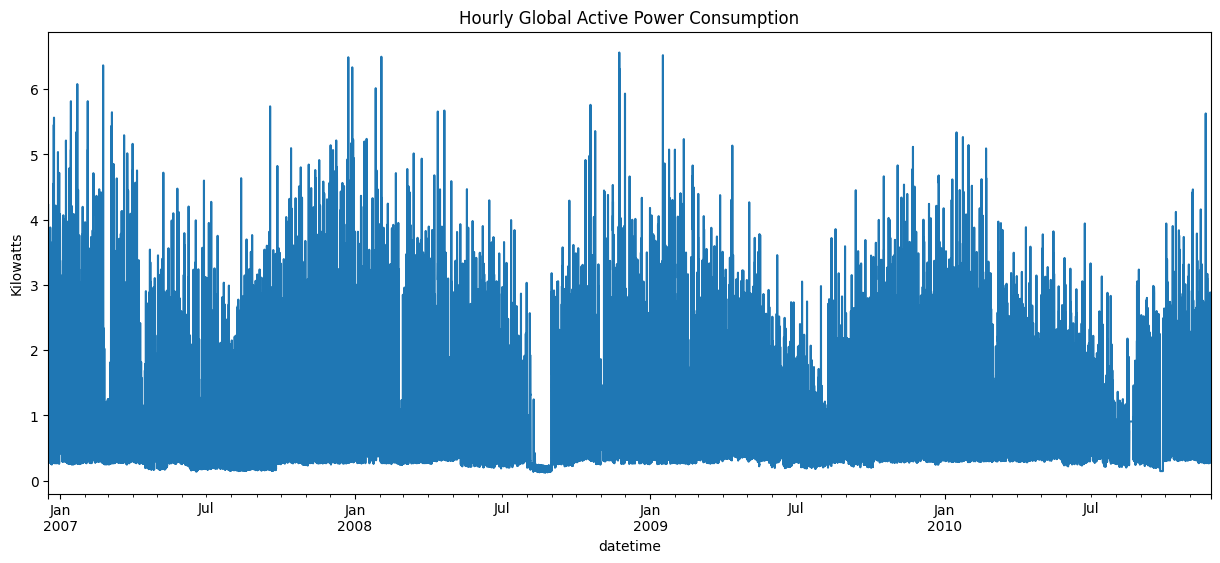

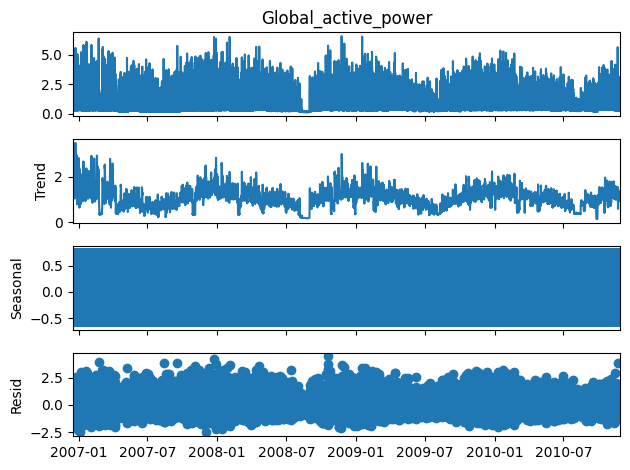

In [2]:
# Plot power consumption
plt.figure(figsize=(15,6))
hourly_df['Global_active_power'].plot(title='Hourly Global Active Power Consumption')
plt.ylabel('Kilowatts')
plt.show()

# Time series decomposition
result = seasonal_decompose(hourly_df['Global_active_power'], model='additive', period=24)
result.plot()
plt.show()

### Exploratory Data Analysis (EDA)

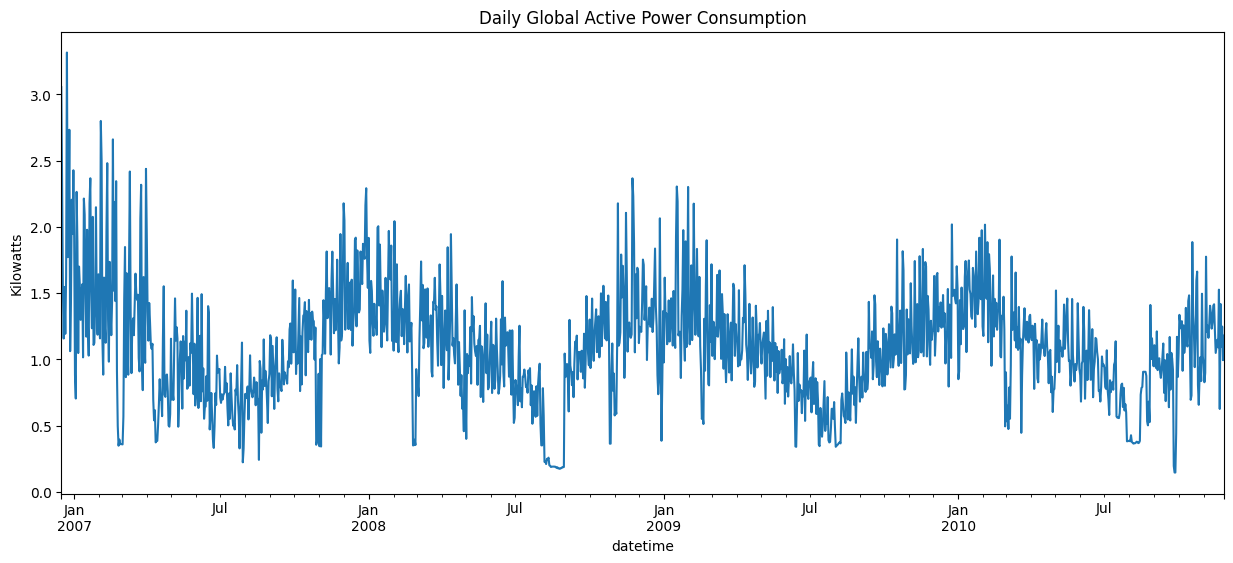

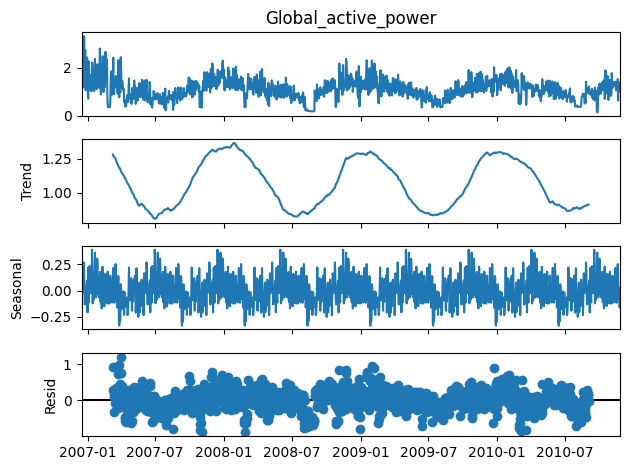

In [4]:

# Plot power consumption
plt.figure(figsize=(15,6))
daily_df['Global_active_power'].plot(title='Daily Global Active Power Consumption')
plt.ylabel('Kilowatts')
plt.show()

# Time series decomposition
result = seasonal_decompose(daily_df['Global_active_power'], model='additive', period=24*7)
result.plot()
plt.show()

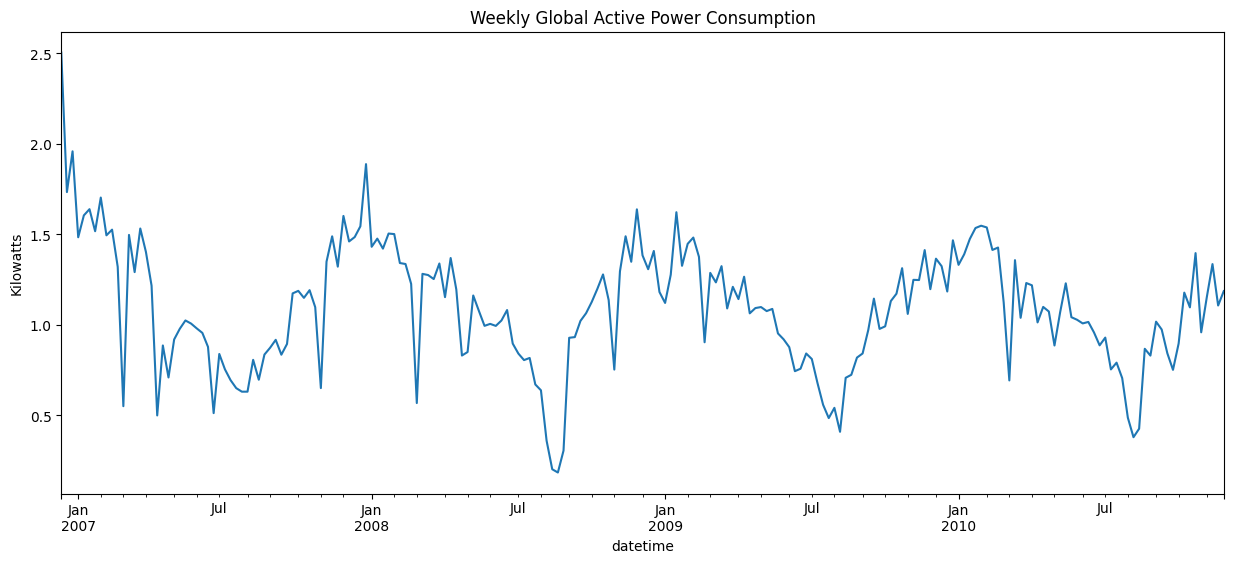

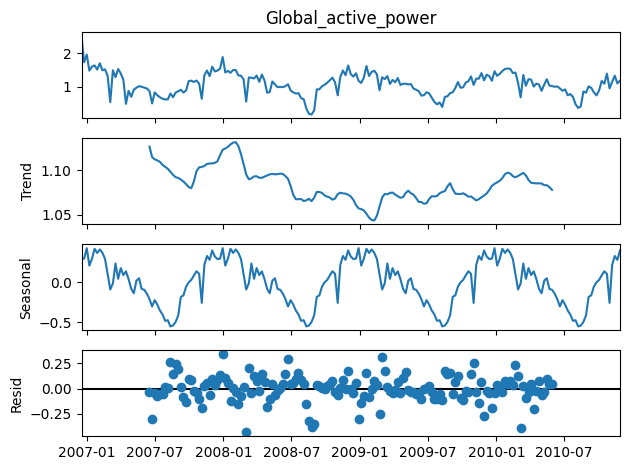

In [5]:
# resample to weekly frequency
weekly_df = df.resample('W').mean()

# Plot power consumption
plt.figure(figsize=(15,6))
weekly_df['Global_active_power'].plot(title='Weekly Global Active Power Consumption')
plt.ylabel('Kilowatts')
plt.show()

#plot decomposition
# Use a smaller period that fits within the available data
result = seasonal_decompose(weekly_df['Global_active_power'], model='additive', period=52)  # Weekly data, period set to 52 weeks (1 year)
result.plot()
plt.show()

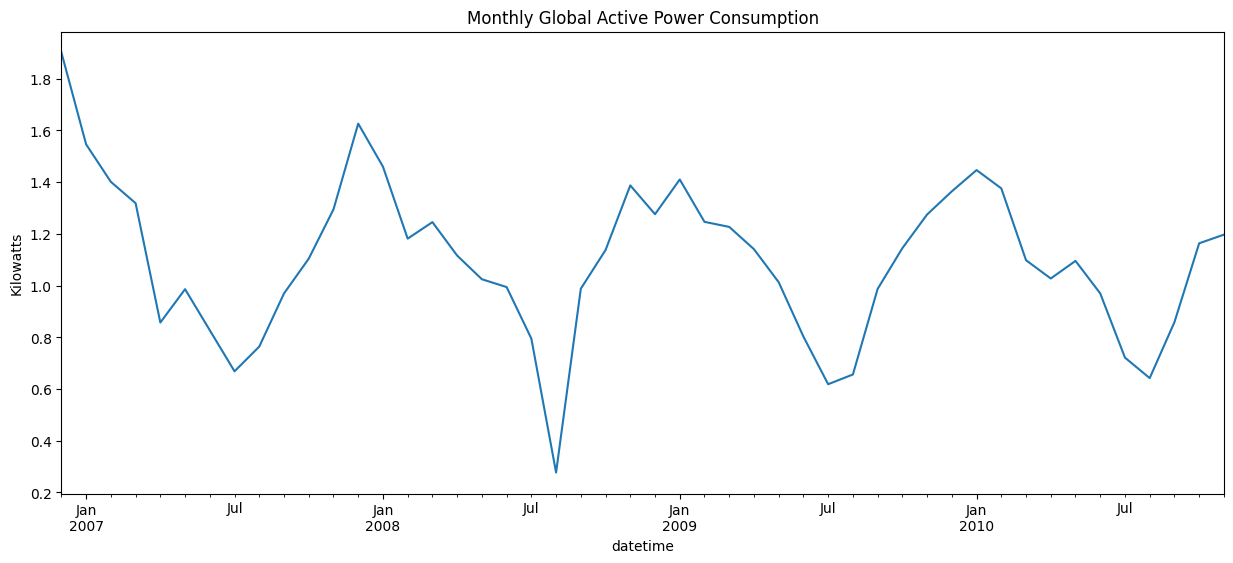

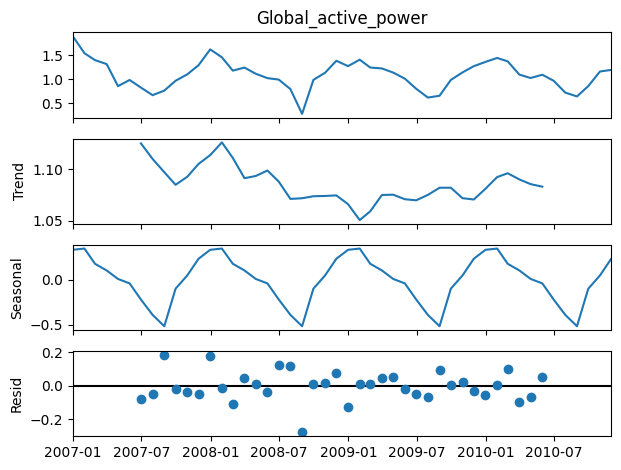

In [6]:
#resample to monthly frequency
monthly_df = df.resample('M').mean()

# Plot power consumption
plt.figure(figsize=(15,6))
monthly_df['Global_active_power'].plot(title='Monthly Global Active Power Consumption')
plt.ylabel('Kilowatts')
plt.show()
#plot decomposition
result = seasonal_decompose(monthly_df['Global_active_power'], model='additive', period=12)  # Monthly data, period set to 12 months
result.plot()
plt.show()

###  Feature Engineering

In [7]:
# Create time-based features
hourly_df['hour'] = hourly_df.index.hour
hourly_df['day_of_week'] = hourly_df.index.dayofweek
hourly_df['month'] = hourly_df.index.month

# Create lag features
hourly_df['lag_24h'] = hourly_df['Global_active_power'].shift(24)
hourly_df['lag_168h'] = hourly_df['Global_active_power'].shift(168)
hourly_df = hourly_df.dropna()

### Model Building ---- ARIMA Approach:

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=540.730, Time=1.88 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=1213.725, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=968.961, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=726.569, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=1211.743, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=654.621, Time=1.49 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=645.075, Time=1.06 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=597.659, Time=2.84 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=602.929, Time=2.99 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=686.129, Time=0.50 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=643.257, Time=2.81 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=626.973, Time=2.82 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=552.229, Time=3.31 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=546.571, Time=1.66 sec
 ARIMA(2,1,1)(1,0,1)[7] intercept   : AIC=564

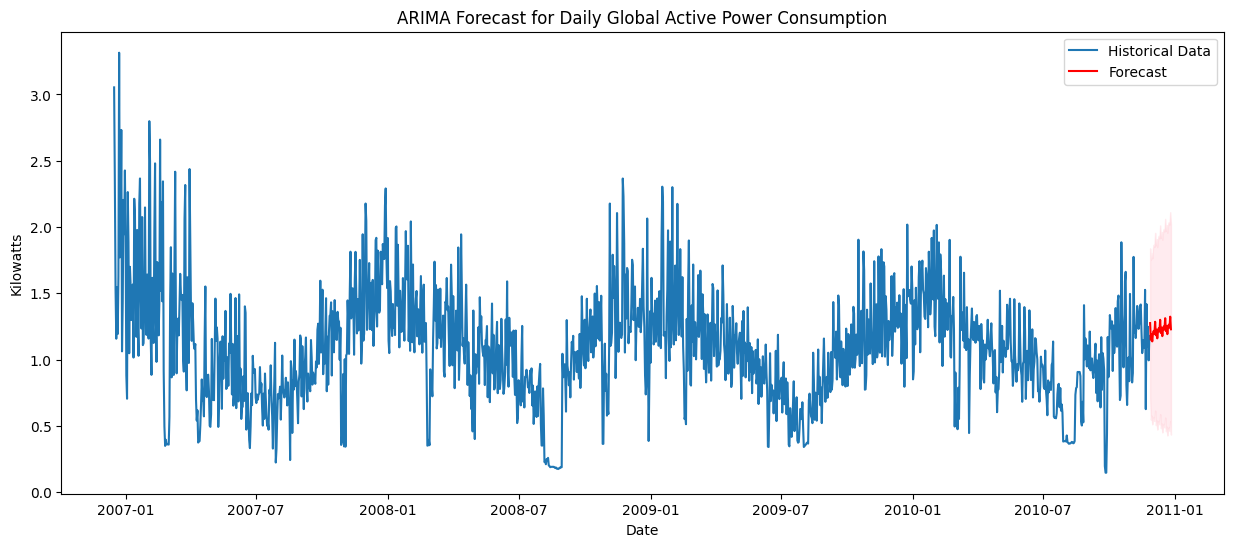

In [10]:
# Fit ARIMA model for daily data
model = auto_arima(daily_df['Global_active_power'], seasonal=True, m=7, 
                    trace=True, error_action='ignore', suppress_warnings=True)
model.summary()
# Forecasting
n_steps = 30  # Forecast for the next 30 days
forecast, conf_int = model.predict(n_periods=n_steps, return_conf_int=True)
forecast_index = pd.date_range(start=daily_df.index[-1] + pd.Timedelta(days=1), periods=n_steps, freq='D')
forecast_series = pd.Series(forecast, index=forecast_index)
# Plot forecast
plt.figure(figsize=(15,6))
plt.plot(daily_df['Global_active_power'], label='Historical Data')
plt.plot(forecast_series, label='Forecast', color='red')
plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)
plt.title('ARIMA Forecast for Daily Global Active Power Consumption')
plt.xlabel('Date')
plt.ylabel('Kilowatts')
plt.legend()
plt.show()



In [15]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping

# Split data into train and test sets (80-20 split)
train_size = int(len(daily_df) * 0.8)
train, test = daily_df[:train_size], daily_df[train_size:]

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train['Global_active_power'].values.reshape(-1, 1))
test_scaled = scaler.transform(test['Global_active_power'].values.reshape(-1, 1))

# Create sequences
def create_sequences(data, sequence_length=60):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, sequence_length=60)
X_test, y_test = create_sequences(test_scaled, sequence_length=60)

# Reshape data for LSTM (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Predict and evaluate
predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print(f"LSTM MAE: {mae:.2f}")
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"LSTM RMSE: {rmse:.2f}")





Epoch 1/50
35/35 [==============================] - 4s 47ms/step - loss: 0.0228 - val_loss: 0.0077
Epoch 2/50
35/35 [==============================] - 1s 31ms/step - loss: 0.0116 - val_loss: 0.0065
Epoch 3/50
35/35 [==============================] - 1s 30ms/step - loss: 0.0110 - val_loss: 0.0068
Epoch 4/50
35/35 [==============================] - 1s 30ms/step - loss: 0.0112 - val_loss: 0.0063
Epoch 5/50
35/35 [==============================] - 1s 32ms/step - loss: 0.0106 - val_loss: 0.0063
Epoch 6/50
35/35 [==============================] - 1s 29ms/step - loss: 0.0109 - val_loss: 0.0063
Epoch 7/50
35/35 [==============================] - 1s 31ms/step - loss: 0.0105 - val_loss: 0.0065
Epoch 8/50
35/35 [==============================] - 1s 31ms/step - loss: 0.0106 - val_loss: 0.0062
Epoch 9/50
35/35 [==============================] - 1s 35ms/step - loss: 0.0107 - val_loss: 0.0063
Epoch 10/50
35/35 [==============================] - 1s 29ms/step - loss: 0.0109 - val_loss: 0.0061
Epoch 11/

In [16]:
forecast_lstm = model.predict(X_test).flatten()
forecast_lstm = scaler.inverse_transform(forecast_lstm.reshape(-1, 1)).flatten()


8/8 [==============================] - 0s 11ms/step


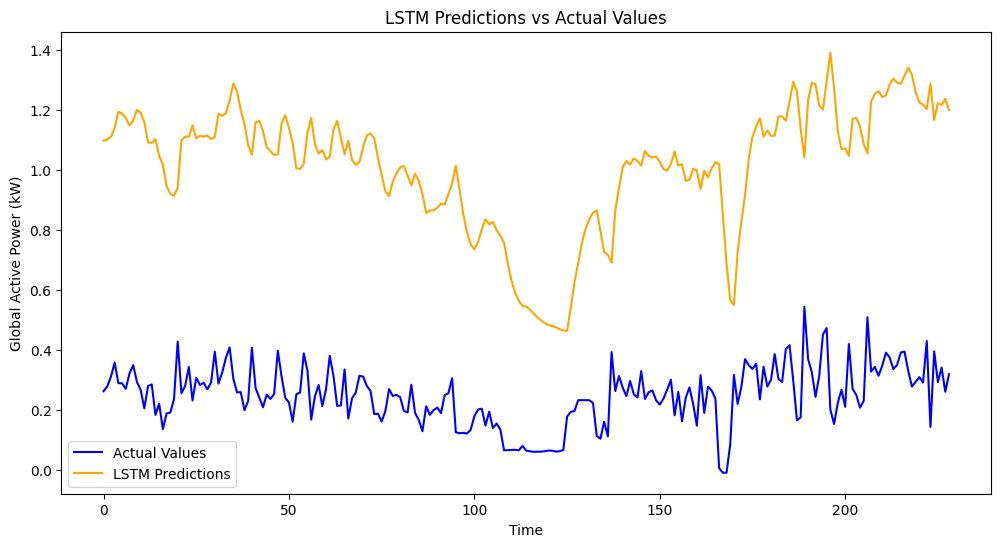

In [18]:

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Values", color='blue')
plt.plot(forecast_lstm, label="LSTM Predictions", color='orange')
plt.title("LSTM Predictions vs Actual Values")
plt.xlabel("Time")
plt.ylabel("Global Active Power (kW)")
plt.legend()
plt.show()



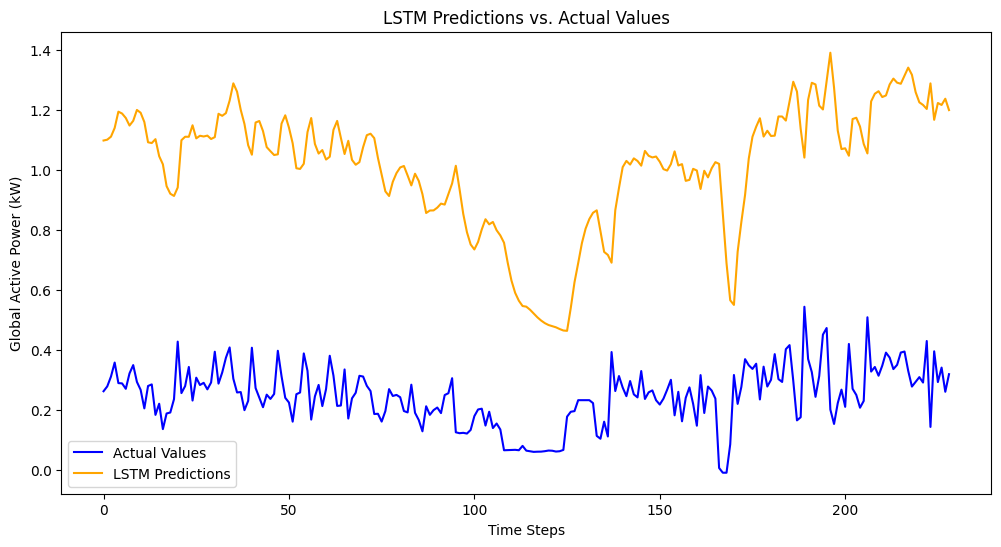

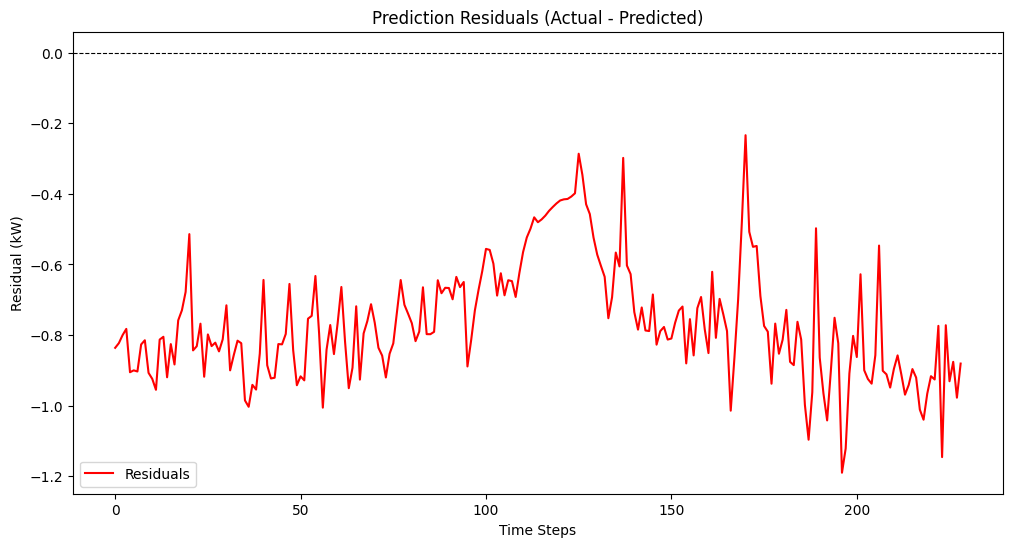

In [19]:
# Overlay predictions and actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Values", color='blue')
plt.plot(forecast_lstm, label="LSTM Predictions", color='orange')
plt.title("LSTM Predictions vs. Actual Values")
plt.xlabel("Time Steps")
plt.ylabel("Global Active Power (kW)")
plt.legend()
plt.show()

# Plot residuals
residuals = y_test - forecast_lstm.flatten()
plt.figure(figsize=(12, 6))
plt.plot(residuals, label="Residuals", color='red')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title("Prediction Residuals (Actual - Predicted)")
plt.xlabel("Time Steps")
plt.ylabel("Residual (kW)")
plt.legend()
plt.show()


In [20]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import ParameterGrid

# Define a function to create the LSTM model
def create_lstm_model(units, dropout_rate, learning_rate, input_shape):
    model = Sequential([
        LSTM(units, activation='relu', input_shape=input_shape, return_sequences=True),
        Dropout(dropout_rate),
        LSTM(units, activation='relu', return_sequences=False),
        Dropout(dropout_rate),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Define the parameter grid
param_grid = {
    "units": [50, 100],
    "dropout_rate": [0.2, 0.3],
    "learning_rate": [0.001, 0.01],
    "batch_size": [32, 64]
}

# Loop through the parameter grid
best_mae = float("inf")
best_params = None
best_model = None
input_shape = (X_train.shape[1], X_train.shape[2])

for params in ParameterGrid(param_grid):
    model = create_lstm_model(params["units"], params["dropout_rate"], params["learning_rate"], input_shape)
    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=params["batch_size"],
        validation_data=(X_test, y_test),
        verbose=0
    )
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)

    if mae < best_mae:
        best_mae = mae
        best_params = params
        best_model = model

print(f"Best Parameters: {best_params}")
print(f"Best MAE: {best_mae}")


8/8 [==============================] - 1s 23ms/step
Best Parameters: {'batch_size': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'units': 100}
Best MAE: 0.056091119516694155


### Compare with Other Models
Now, let’s compare the LSTM model with other methods, such as SARIMA and a baseline moving average.

Moving Average Baseline

Moving Average MAE: 0.3549782938661489


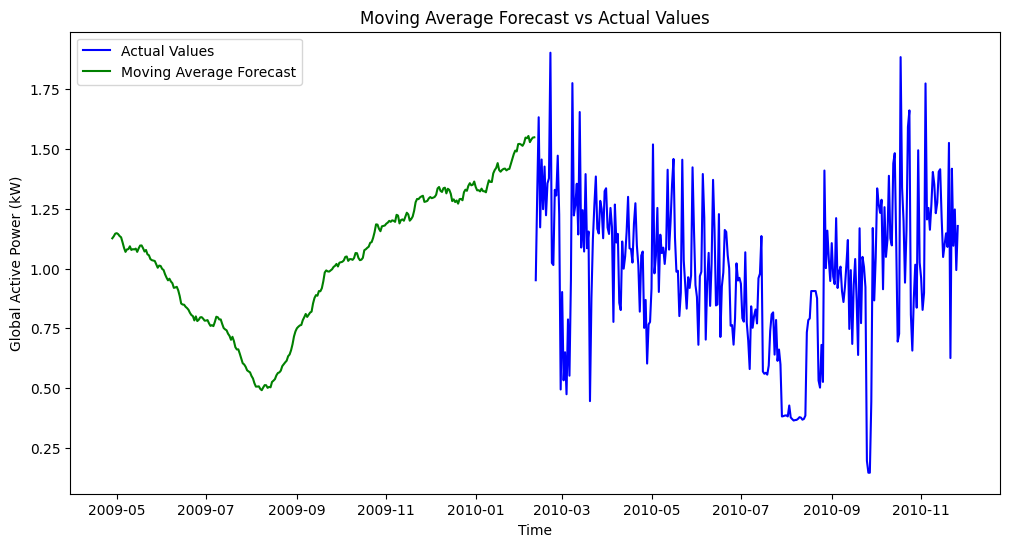

In [21]:
# Moving average forecast (simple baseline)
rolling_mean = train['Global_active_power'].rolling(window=24).mean()
baseline_predictions = rolling_mean.iloc[-len(test):]
mae_baseline = mean_absolute_error(test['Global_active_power'], baseline_predictions)
print(f"Moving Average MAE: {mae_baseline}")

# Plot moving average forecast
plt.figure(figsize=(12, 6))
plt.plot(test['Global_active_power'], label="Actual Values", color='blue')
plt.plot(baseline_predictions, label="Moving Average Forecast", color='green')
plt.title("Moving Average Forecast vs Actual Values")
plt.xlabel("Time")
plt.ylabel("Global Active Power (kW)")
plt.legend()
plt.show()


SARIMA Model

SARIMA MAE: 0.509319038219437


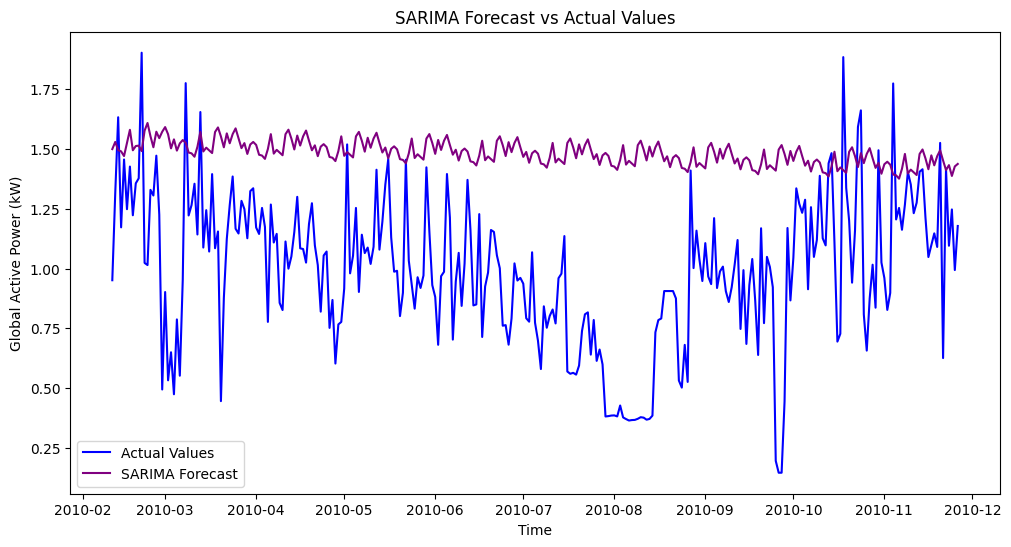

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA model
sarima_model = SARIMAX(train['Global_active_power'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 24)).fit()
sarima_predictions = sarima_model.forecast(steps=len(test))
mae_sarima = mean_absolute_error(test['Global_active_power'], sarima_predictions)
print(f"SARIMA MAE: {mae_sarima}")

# Plot SARIMA forecast
plt.figure(figsize=(12, 6))
plt.plot(test['Global_active_power'], label="Actual Values", color='blue')
plt.plot(sarima_predictions, label="SARIMA Forecast", color='purple')
plt.title("SARIMA Forecast vs Actual Values")
plt.xlabel("Time")
plt.ylabel("Global Active Power (kW)")
plt.legend()
plt.show()


Compare all models in terms of MAE:

In [24]:
results = {
    "LSTM": best_mae,
    "SARIMA": mae_sarima,
    "Moving Average": mae_baseline
}

for model, mae in results.items():
    print(f"{model}: MAE = {mae:.3f}")


LSTM: MAE = 0.056
SARIMA: MAE = 0.509
Moving Average: MAE = 0.355


Visualize Model Comparisons

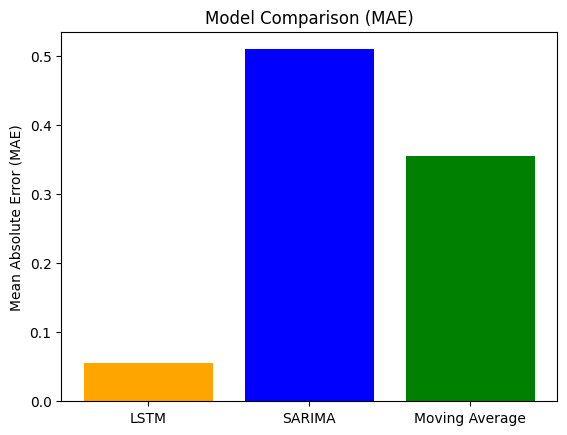

In [25]:
import matplotlib.pyplot as plt

# Plot model comparison
plt.bar(results.keys(), results.values(), color=['orange', 'blue', 'green'])
plt.title("Model Comparison (MAE)")
plt.ylabel("Mean Absolute Error (MAE)")
plt.show()


In [26]:
from pmdarima import auto_arima

# Train Auto ARIMA on the training dataset
auto_model = auto_arima(train['Global_active_power'],
                        seasonal=True,
                        m=24,  # Assuming hourly seasonal cycle
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)

# Print the summary of the best model
print(auto_model.summary())

# Forecast future values
forecast_auto_arima = auto_model.predict(n_periods=len(test))
mae_auto_arima = mean_absolute_error(test['Global_active_power'], forecast_auto_arima)
print(f"Auto ARIMA MAE: {mae_auto_arima:.3f}")


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=inf, Time=4.46 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=1392.603, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=829.428, Time=1.83 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=959.445, Time=0.53 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=3687.211, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=848.448, Time=0.06 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=831.428, Time=9.62 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=2.03 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=830.151, Time=1.63 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=8.13 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=1246.544, Time=0.91 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=810.265, Time=2.07 sec
 ARIMA(2,0,0)(0,0,0)[24] intercept   : AIC=822.597, Time=0.11 sec
 ARIMA(2,0,0)(2,0,0)[24] intercept   : AIC=812.172, Time=10.01 sec
 ARIMA(2,0,0)(1,0,1)[24] intercept   : AI

In [27]:
import optuna
from statsmodels.tsa.statespace.sarimax import SARIMAX

def objective(trial):
    # Suggest parameters for SARIMA
    p = trial.suggest_int('p', 0, 3)
    d = trial.suggest_int('d', 0, 2)
    q = trial.suggest_int('q', 0, 3)
    P = trial.suggest_int('P', 0, 2)
    D = trial.suggest_int('D', 0, 1)
    Q = trial.suggest_int('Q', 0, 2)
    m = trial.suggest_int('m', 24, 24)  # Hourly seasonal cycle

    # Fit SARIMA model
    model = SARIMAX(train['Global_active_power'], 
                    order=(p, d, q), 
                    seasonal_order=(P, D, Q, m))
    results = model.fit(disp=False)
    
    # Forecast and calculate MAE
    forecast = results.forecast(steps=len(test))
    mae = mean_absolute_error(test['Global_active_power'], forecast)
    return mae

# Run Optuna optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

# Print best parameters and MAE
print(f"Best parameters: {study.best_params}")
print(f"Best MAE: {study.best_value}")


[I 2025-04-28 15:22:40,108] A new study created in memory with name: no-name-111fc5ae-819d-4e00-b5af-4d25f58a0b22
[I 2025-04-28 15:22:40,477] Trial 0 finished with value: 0.5708387158928865 and parameters: {'p': 0, 'd': 1, 'q': 1, 'P': 1, 'D': 0, 'Q': 0, 'm': 24}. Best is trial 0 with value: 0.5708387158928865.
[I 2025-04-28 15:22:41,025] Trial 1 finished with value: 0.5647244439156125 and parameters: {'p': 1, 'd': 1, 'q': 1, 'P': 0, 'D': 0, 'Q': 1, 'm': 24}. Best is trial 1 with value: 0.5647244439156125.
[I 2025-04-28 15:23:08,833] Trial 2 finished with value: 0.3754723126502702 and parameters: {'p': 1, 'd': 0, 'q': 2, 'P': 0, 'D': 1, 'Q': 2, 'm': 24}. Best is trial 2 with value: 0.3754723126502702.
c:\Users\bhusa\OneDrive\Bijlagen\Desktop\EindProef_energy_forecast\energy_forecast\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found

Best parameters: {'p': 0, 'd': 2, 'q': 1, 'P': 1, 'D': 0, 'Q': 2, 'm': 24}
Best MAE: 0.28107782495865097


In [28]:
# Add an exogenous variable (e.g., Sub_metering_1)
exog_train = train[['Sub_metering_1']]
exog_test = test[['Sub_metering_1']]

# Fit SARIMAX model with exogenous variables
model_exog = SARIMAX(train['Global_active_power'], 
                     order=(1, 1, 1),
                     seasonal_order=(1, 1, 1, 24),
                     exog=exog_train)
results_exog = model_exog.fit()

# Forecast using exogenous variable
forecast_exog = results_exog.forecast(steps=len(test), exog=exog_test)
mae_exog = mean_absolute_error(test['Global_active_power'], forecast_exog)
print(f"SARIMAX with Exogenous Variables MAE: {mae_exog:.3f}")


SARIMAX with Exogenous Variables MAE: 0.452


SARIMA (Manual): MAE = 0.509
Auto ARIMA: MAE = 0.512
SARIMAX with Exog: MAE = 0.452


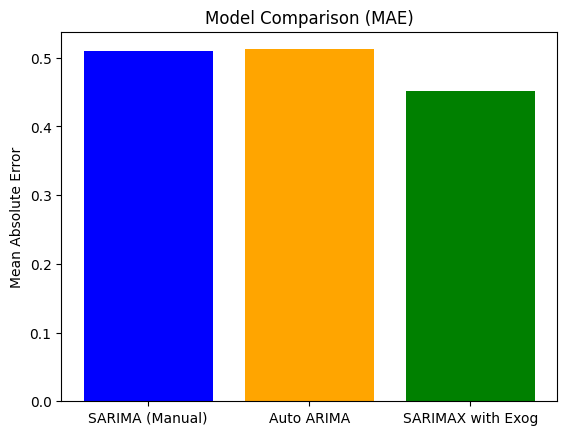

In [29]:
results = {
    "SARIMA (Manual)": mae_sarima,
    "Auto ARIMA": mae_auto_arima,
    "SARIMAX with Exog": mae_exog
}

for model, mae in results.items():
    print(f"{model}: MAE = {mae:.3f}")

# Visualize results
import matplotlib.pyplot as plt

plt.bar(results.keys(), results.values(), color=['blue', 'orange', 'green'])
plt.title("Model Comparison (MAE)")
plt.ylabel("Mean Absolute Error")
plt.show()
